In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from plotting_utils import save_figure
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter("ignore")
from num_cat_transformers import PreprocessingPipeline
from k_means_clusters import cluster_and_visualize
from dimensionality_reduction import pca_reduction, tsne_reduction, umap_reduction



# Use the warnings filter or suppress specific warning types

%matplotlib inline

In [2]:
# read the data from the csv file
df = pd.read_csv('/Users/annabzinkowska/DTU/master_thesis/data/processed_data_all_vol_1.csv')

In [3]:
df.head()

,product_id,description,month_mode,quarter_mode,year_mode,day_week_mode,quantity_sum,price_sum,unit_weight,customer_country_mode,customer_country_count,customer_id_count,category,unit_price_mean,description_original
0,010004,cfcf sfy bolted hanger nptf stud viton,2,1,2020,2,6,232.92,0.124,DK,1,1,-1,38.8200,"C24FCF-1/2-SFY-S BOLTED HANGER, N..."
1,010005,cfcf sfy bolted hanger nptf stud viton,10,4,2019,2,200,1774.00,0.259,CO,1,1,-1,8.8700,"C24FCF-1-SFY-S BOLTED HANGER, N..."
2,010006,cfcf sfy bolted hanger nptf stud viton,10,4,2019,2,300,1848.00,0.276,CO,1,1,-1,6.1600,"C24FCF-1 1/2-SFY-S BOLTED HANGER, N..."
3,010015,cfcf sfy bolted hanger nptf stud viton,1,1,2019,2,300,2115.00,0.318,SE,2,2,-1,7.0500,"C24FCF-2-SFY-S BOLTED HANGER, N..."
4,010040,cfcf sfy bolted hanger nptf stud viton,1,1,2019,2,400,3119.00,0.363,CO,2,2,-1,7.7975,"C24FCF-3-SFY-S BOLTED HANGER, N..."


In [25]:
num_cols = ['quantity_sum', 'price_sum', 'unit_weight', 'unit_price_mean', 'customer_id_count', 'customer_country_count']

In [26]:
# Plotting pairplot
corr_plot = sns.pairplot(data=df[num_cols], diag_kind="kde", corner=True)

# Adjusting the layout to ensure everything fits well
plt.tight_layout()

# Add space at the top for the title
plt.subplots_adjust(top=0.95)

# Add a title above the plot using plt.suptitle()
plt.suptitle('Pairwise Distribution of Numerical Features')

# Saving the pairplot using save_figure function
save_figure(corr_plot.fig, 'corr_dist_plot')

plt.show()

In [27]:
df[num_cols].describe()

In [28]:
# Assuming you've already imported the necessary libraries and defined the save_figure function

plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

# Adjust the layout to ensure everything fits
plt.tight_layout()

# Save the figure using the save_figure function
fig = plt.gcf()  # Gets the current figure
save_figure(fig, 'corr_feat_heatmap')

plt.show()


In [32]:
categorical_columns = ['month_mode', 'customer_country_mode']
numerical_columns = []
log_transform_columns = ['quantity_sum', 'price_sum', 'unit_weight', 'unit_price_mean', 'customer_id_count','customer_country_count']

pipeline = PreprocessingPipeline(categorical_columns, numerical_columns, log_transform_columns)
df_transformed = pipeline.fit_transform(df)
transformed_df_with_headers = pipeline.get_transformed_df()

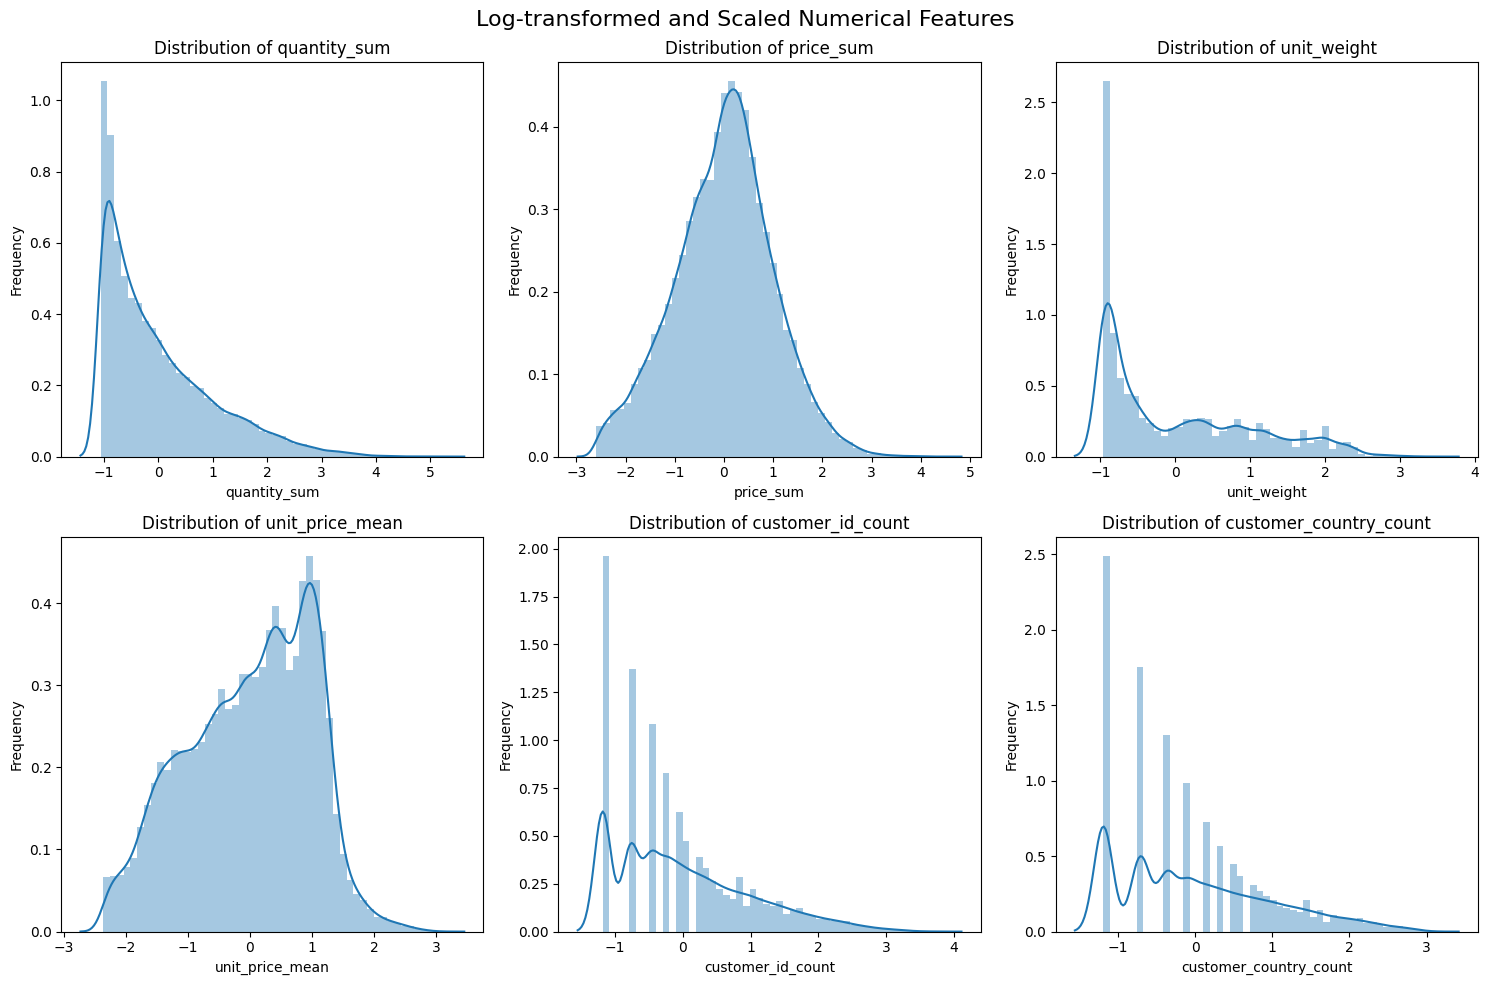

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features to plot
features = ['quantity_sum', 'price_sum', 'unit_weight', 'unit_price_mean', 'customer_id_count', 'customer_country_count']

# Create subplots
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for idx, feature in enumerate(features):
    row = idx // n_cols
    col = idx % n_cols
    sns.distplot(transformed_df_with_headers[feature], kde=True, ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of {feature}')
    axs[row, col].set_ylabel('Frequency')

# Add a main title to the subplots
fig.suptitle('Log-transformed and Scaled Numerical Features', fontsize=16)

# Adjust subplot parameters to fit the main title
fig.subplots_adjust(top=0.92)

plt.tight_layout()

# Save the figure
save_figure(fig, 'all_data_transformed_multiple_histograms')

plt.show()

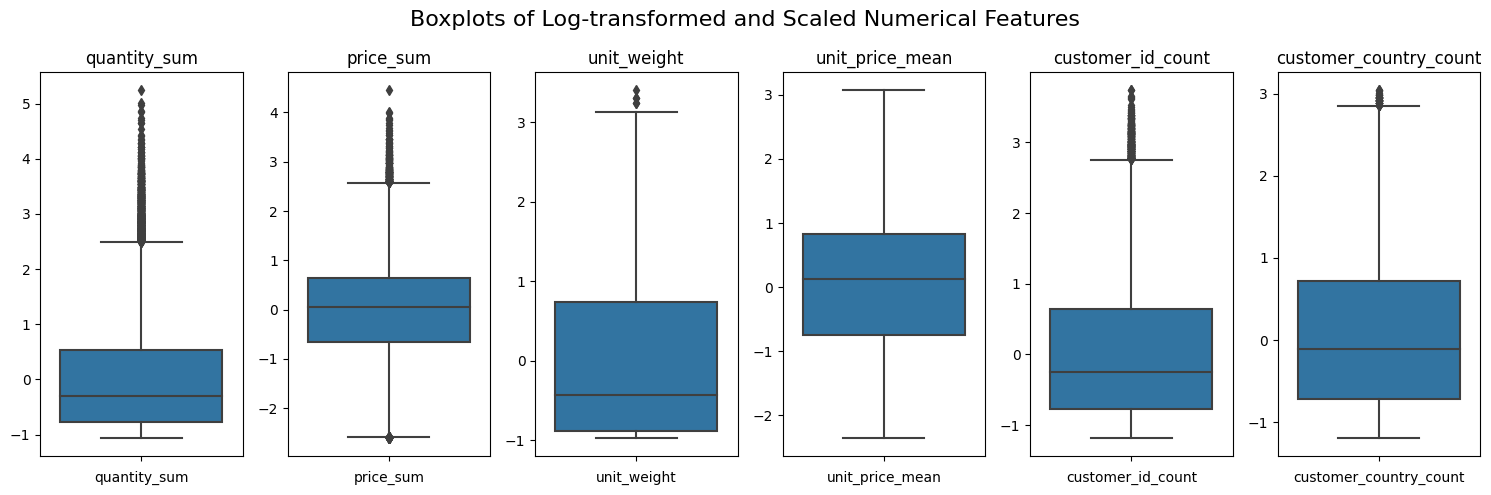

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features to plot
features = ['quantity_sum', 'price_sum', 'unit_weight', 'unit_price_mean', 'customer_id_count', 'customer_country_count']

# Setting up the figure and axis
fig, axs = plt.subplots(1, len(features), figsize=(15, 5))

# Loop over each feature and plot a boxplot on its respective axis
for i, feature in enumerate(features):
    sns.boxplot(y=transformed_df_with_headers[feature], ax=axs[i])
    axs[i].set_title(f'{feature}')
    axs[i].set_ylabel('')  # To avoid repeated y-labels
    axs[i].set_xlabel(feature)

# Add a main title to the subplots
fig.suptitle('Boxplots of Log-transformed and Scaled Numerical Features', fontsize=16)

# Adjust subplot parameters to fit the main title
fig.subplots_adjust(top=0.92)

plt.tight_layout()

# Save the figure
save_figure(fig, 'all_data_transformed_multiple_boxplots')

plt.show()


## PCA

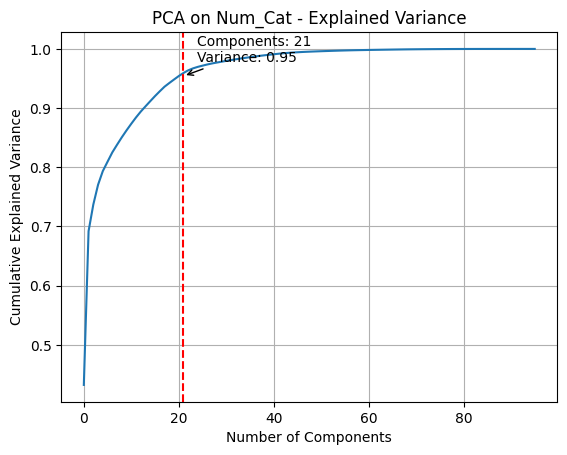

In [9]:
X_pca = pca_reduction(df_transformed, 'Num_Cat')

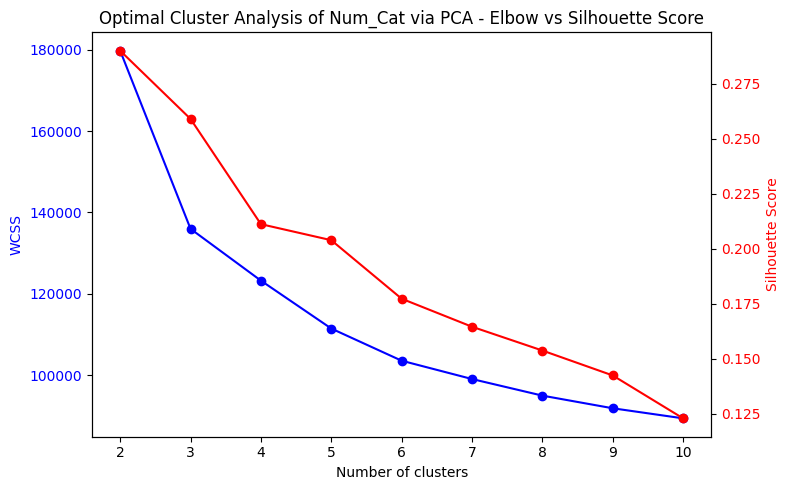

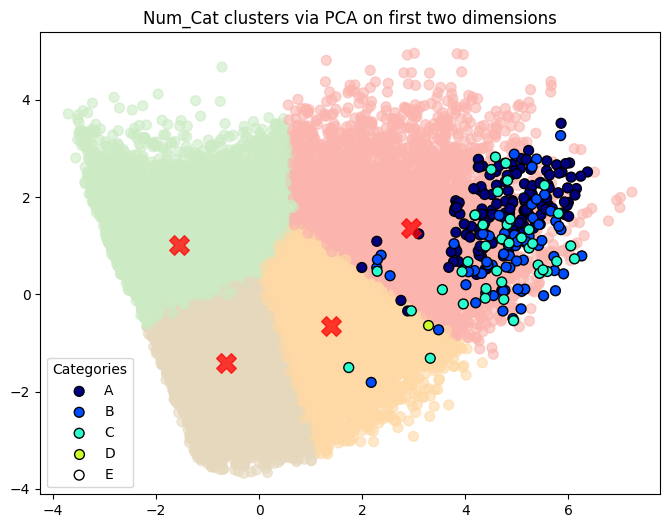

,product_id,description,month_mode,quarter_mode,year_mode,day_week_mode,quantity_sum,price_sum,unit_weight,customer_country_mode,customer_country_count,customer_id_count,category,unit_price_mean,description_original,Num_Cat_PCA_Cluster_Labels,Num_Cat_PCA_Distance_to_Centroid
0,010004,cfcf sfy bolted hanger nptf stud viton,2,1,2020,2,6,232.92,0.124,DK,1,1,-1,38.8200,"C24FCF-1/2-SFY-S BOLTED HANGER, N...",3,1.890157
1,010005,cfcf sfy bolted hanger nptf stud viton,10,4,2019,2,200,1774.00,0.259,CO,1,1,-1,8.8700,"C24FCF-1-SFY-S BOLTED HANGER, N...",3,1.990384
2,010006,cfcf sfy bolted hanger nptf stud viton,10,4,2019,2,300,1848.00,0.276,CO,1,1,-1,6.1600,"C24FCF-1 1/2-SFY-S BOLTED HANGER, N...",3,2.178425
3,010015,cfcf sfy bolted hanger nptf stud viton,1,1,2019,2,300,2115.00,0.318,SE,2,2,-1,7.0500,"C24FCF-2-SFY-S BOLTED HANGER, N...",3,2.153515
4,010040,cfcf sfy bolted hanger nptf stud viton,1,1,2019,2,400,3119.00,0.363,CO,2,2,-1,7.7975,"C24FCF-3-SFY-S BOLTED HANGER, N...",3,2.093951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35181,TE929K,slide bearing,3,1,2016,4,636,15681.71,0.011,US,20,23,-1,24.6568,SLIDE BEARING ...,0,1.868715
35182,TE980931,weld adapt tz npt sch pipe,12,4,2017,4,6,524.95,0.270,GB,2,2,-1,87.4917,"WELD.ADAPT. TZ-74 NPT/1½""SCH40 PIP...",3,1.245854
35183,TEB6042,bottom liner,10,3,2017,1,158,1827.25,0.038,SE,15,18,-1,11.5649,BOTTOM LINER ...,2,1.667017
35184,TEB604Z,stem,6,1,2020,1,13,2586.04,1.150,US,4,6,-1,198.9262,STEM ...,3,1.657211


In [10]:
cluster_and_visualize(X_pca, df, reduction_method_name='PCA', feature_type='Num_Cat')

## t-SNE

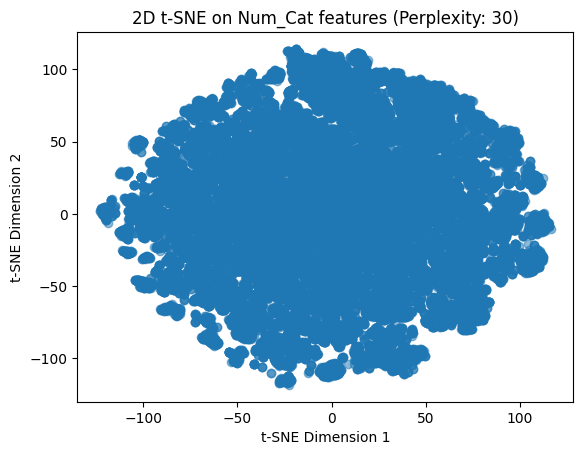

In [16]:
X_tsne = tsne_reduction(df_transformed, 'Num_Cat', perplexity=30, metric='euclidean')

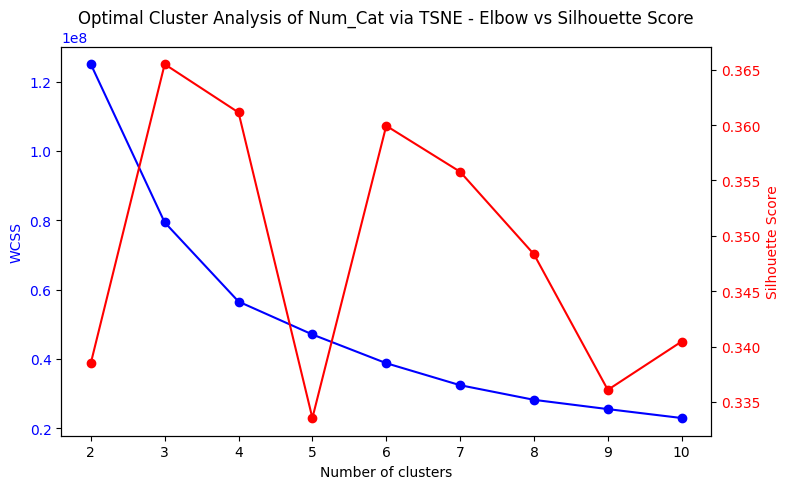

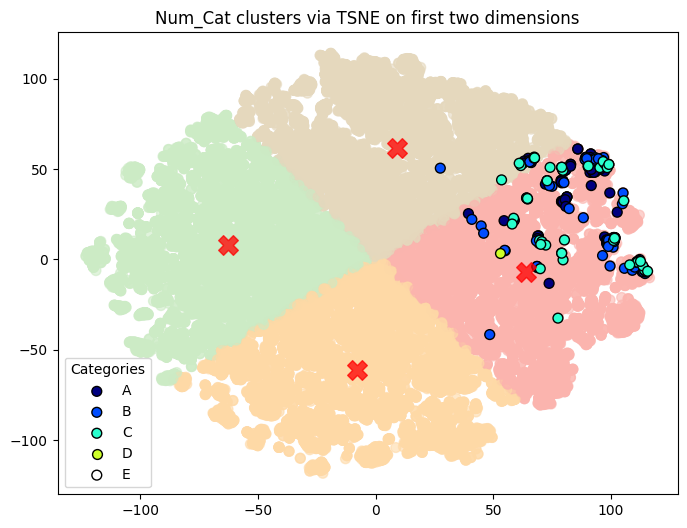

,product_id,description,month_mode,quarter_mode,year_mode,day_week_mode,quantity_sum,price_sum,unit_weight,customer_country_mode,customer_country_count,customer_id_count,category,unit_price_mean,description_original,Num_Cat_PCA_Cluster_Labels,Num_Cat_PCA_Distance_to_Centroid,Num_Cat_TSNE_Cluster_Labels,Num_Cat_TSNE_Distance_to_Centroid
0,010004,cfcf sfy bolted hanger nptf stud viton,2,1,2020,2,6,232.92,0.124,DK,1,1,-1,38.8200,"C24FCF-1/2-SFY-S BOLTED HANGER, N...",3,1.890157,2,28.056835
1,010005,cfcf sfy bolted hanger nptf stud viton,10,4,2019,2,200,1774.00,0.259,CO,1,1,-1,8.8700,"C24FCF-1-SFY-S BOLTED HANGER, N...",3,1.990384,2,33.934891
2,010006,cfcf sfy bolted hanger nptf stud viton,10,4,2019,2,300,1848.00,0.276,CO,1,1,-1,6.1600,"C24FCF-1 1/2-SFY-S BOLTED HANGER, N...",3,2.178425,2,33.890827
3,010015,cfcf sfy bolted hanger nptf stud viton,1,1,2019,2,300,2115.00,0.318,SE,2,2,-1,7.0500,"C24FCF-2-SFY-S BOLTED HANGER, N...",3,2.153515,0,73.294510
4,010040,cfcf sfy bolted hanger nptf stud viton,1,1,2019,2,400,3119.00,0.363,CO,2,2,-1,7.7975,"C24FCF-3-SFY-S BOLTED HANGER, N...",3,2.093951,0,73.691719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35181,TE929K,slide bearing,3,1,2016,4,636,15681.71,0.011,US,20,23,-1,24.6568,SLIDE BEARING ...,0,1.868715,0,41.550747
35182,TE980931,weld adapt tz npt sch pipe,12,4,2017,4,6,524.95,0.270,GB,2,2,-1,87.4917,"WELD.ADAPT. TZ-74 NPT/1½""SCH40 PIP...",3,1.245854,2,14.380647
35183,TEB6042,bottom liner,10,3,2017,1,158,1827.25,0.038,SE,15,18,-1,11.5649,BOTTOM LINER ...,2,1.667017,0,27.391335
35184,TEB604Z,stem,6,1,2020,1,13,2586.04,1.150,US,4,6,-1,198.9262,STEM ...,3,1.657211,3,10.707470


In [17]:
cluster_and_visualize(X_tsne, df, reduction_method_name='TSNE', feature_type='Num_Cat')

## UMAP

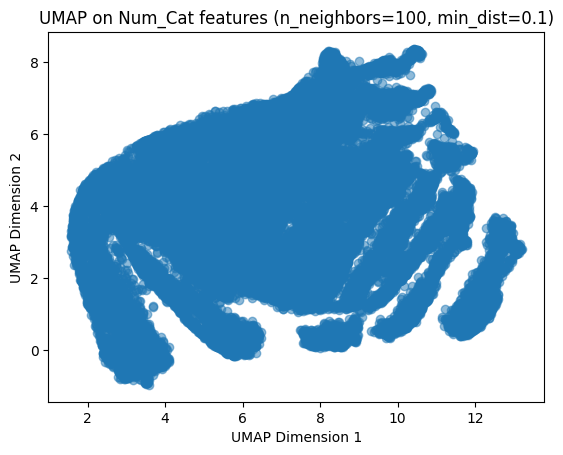

In [21]:
X_umap = umap_reduction(df_transformed, n_neighbors=100, min_dist=0.1, metric='euclidean', feature_type='Num_Cat')

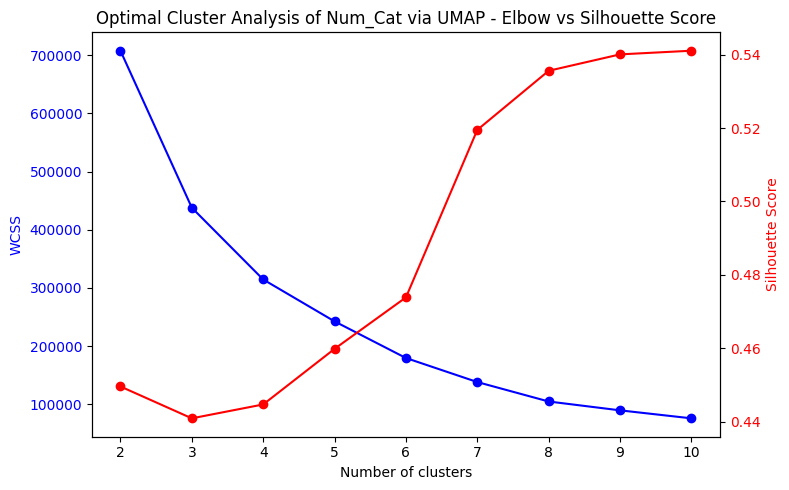

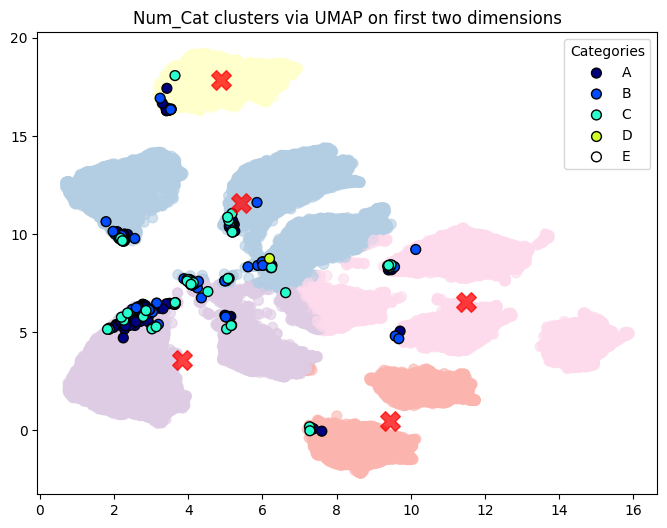

,product_id,description,month_mode,quarter_mode,year_mode,day_week_mode,quantity_sum,price_sum,unit_weight,customer_country_mode,...,customer_id_count,category,unit_price_mean,description_original,Num_Cat_PCA_Cluster_Labels,Num_Cat_PCA_Distance_to_Centroid,Num_Cat_TSNE_Cluster_Labels,Num_Cat_TSNE_Distance_to_Centroid,Num_Cat_UMAP_Cluster_Labels,Num_Cat_UMAP_Distance_to_Centroid
0,010004,cfcf sfy bolted hanger nptf stud viton,2,1,2020,2,6,232.92,0.124,DK,...,1,-1,38.8200,"C24FCF-1/2-SFY-S BOLTED HANGER, N...",3,1.890157,2,28.056835,3,0.957577
1,010005,cfcf sfy bolted hanger nptf stud viton,10,4,2019,2,200,1774.00,0.259,CO,...,1,-1,8.8700,"C24FCF-1-SFY-S BOLTED HANGER, N...",3,1.990384,2,33.934891,0,2.420950
2,010006,cfcf sfy bolted hanger nptf stud viton,10,4,2019,2,300,1848.00,0.276,CO,...,1,-1,6.1600,"C24FCF-1 1/2-SFY-S BOLTED HANGER, N...",3,2.178425,2,33.890827,0,2.418716
3,010015,cfcf sfy bolted hanger nptf stud viton,1,1,2019,2,300,2115.00,0.318,SE,...,2,-1,7.0500,"C24FCF-2-SFY-S BOLTED HANGER, N...",3,2.153515,0,73.294510,1,4.317585
4,010040,cfcf sfy bolted hanger nptf stud viton,1,1,2019,2,400,3119.00,0.363,CO,...,2,-1,7.7975,"C24FCF-3-SFY-S BOLTED HANGER, N...",3,2.093951,0,73.691719,1,4.250095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35181,TE929K,slide bearing,3,1,2016,4,636,15681.71,0.011,US,...,23,-1,24.6568,SLIDE BEARING ...,0,1.868715,0,41.550747,2,1.208242
35182,TE980931,weld adapt tz npt sch pipe,12,4,2017,4,6,524.95,0.270,GB,...,2,-1,87.4917,"WELD.ADAPT. TZ-74 NPT/1½""SCH40 PIP...",3,1.245854,2,14.380647,4,4.426679
35183,TEB6042,bottom liner,10,3,2017,1,158,1827.25,0.038,SE,...,18,-1,11.5649,BOTTOM LINER ...,2,1.667017,0,27.391335,0,2.122776
35184,TEB604Z,stem,6,1,2020,1,13,2586.04,1.150,US,...,6,-1,198.9262,STEM ...,3,1.657211,3,10.707470,1,2.075590


In [19]:
cluster_and_visualize(X_umap, df, reduction_method_name='UMAP', feature_type='Num_Cat')

In [20]:
# write df to data folder with name df_Num_Cat_clusters.csv
df.to_csv('../data/df_Num_Cat_clusters.csv', index=False)